# Convolutional neural network
## Fashion-MNIST Dataset

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

In [2]:
torch.cuda.is_available()

True

### Data loaders

In [3]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [4]:
'''
train_data.train_data = train_data.train_data.to(torch.device('cuda:0'))
train_data.train_labels = train_data.train_labels.to(torch.device('cuda:0'))

test_data.test_data = test_data.test_data.to(torch.device('cuda:0'))
test_data.test_labels = test_data.test_labels.to(torch.device('cuda:0'))
'''

"\ntrain_data.train_data = train_data.train_data.to(torch.device('cuda:0'))\ntrain_data.train_labels = train_data.train_labels.to(torch.device('cuda:0'))\n\ntest_data.test_data = test_data.test_data.to(torch.device('cuda:0'))\ntest_data.test_labels = test_data.test_labels.to(torch.device('cuda:0'))\n"

In [5]:
torch.cuda.memory_allocated()

0

In [6]:
for images, labels in train_loader:
    break

In [7]:
print(labels)

tensor([9, 9, 3, 9, 4, 6, 3, 2, 6, 1])


In [8]:
it = 0
for i in labels:
    print(f'Picture {it+1}: {class_names[i]}')
    it += 1

Picture 1: Boot
Picture 2: Boot
Picture 3: Dress
Picture 4: Boot
Picture 5: Coat
Picture 6: Shirt
Picture 7: Dress
Picture 8: Sweater
Picture 9: Shirt
Picture 10: Trouser


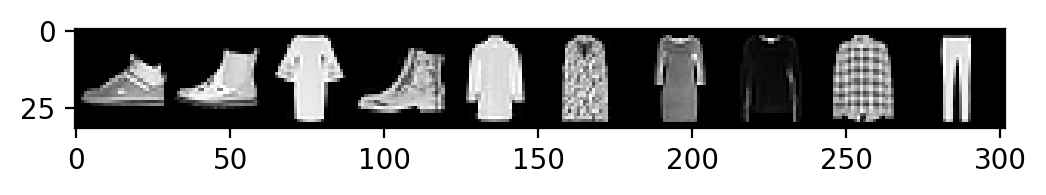

In [9]:
img = make_grid(images, nrow=10)
plt.figure(dpi=200)
plt.imshow(np.transpose(img.numpy(),(1,2,0)))

### Convolutional Neural Network Model

In [10]:
class ConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv2d(1,8,3,1) # 1x28x28 --> 1x26x26 x8
        #pooling                        # 1x26x26 --> 1x13x13 x8
        self.conv2 = nn.Conv2d(8,16,3,1)# 1x13x13 --> 1x11x11 x16
        #pooling                        # 1x11x11 --> 1x5x5 x16
        self.fc1 = nn.Linear(5*5*16,256)    # 400 --> 120
        self.fc2 = nn.Linear(256,128)     # 120 --> 10
        self.fc3 = nn.Linear(128,10)
        
    def forward(self,X):
        
        X = self.conv1(X)
        X = F.relu(X)
        X = F.max_pool2d(X,2,2)
        X = self.conv2(X)
        X = F.max_pool2d(X,2,2)
        X = F.relu(X)
        X = X.view(-1,5*5*16)
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)
        X = F.log_softmax(X,dim=1)
        
        return X 
        

In [11]:
torch.manual_seed(101)
model = ConvolutionalNeuralNetwork()
model = model.cuda()

In [12]:
next(model.parameters()).is_cuda

True

In [13]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [14]:
count_parameters(model)

      72
       8
    1152
      16
  102400
     256
   32768
     128
    1280
      10
________
  138090


### Loss function and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [16]:
#for b, (X_train,y_train) in enumerate(train_loader):
#    break

### Model training

In [17]:
import time

start_time = time.time()

epochs = 10

train_losses = []
test_losses = []

for epoch in range(0,epochs):
    trn_corr = 0
    tst_corr = 0
    
    # train batches
    for b, (X_train,y_train) in enumerate(train_loader):
        
        X_train = X_train.to(torch.device('cuda:0'))
        y_train = y_train.to(torch.device('cuda:0'))
        
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        # number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(loss)
        
    # test batches
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            
            X_test = X_test.to(torch.device('cuda:0'))
            y_test = y_test.to(torch.device('cuda:0'))
            
            y_pred = model(X_test)
            loss = criterion(y_pred,y_test)
            
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
            
    test_losses.append(loss)

    print(f'Epoch {epoch} || train loss = {train_losses[epoch]} || test loss = {test_losses[epoch]}')
    print(f'-> accuracy train = {trn_corr.item()/60000} || -> accuracy test = {tst_corr.item()/10000}')
            
stop_time = time.time() - start_time

print(f'Total time = {stop_time/60} minutes')

Epoch 0 || train loss = 0.8660667538642883 || test loss = 0.3579249978065491
-> accuracy train = 0.7148333333333333 || -> accuracy test = 0.7787
Epoch 1 || train loss = 0.23793211579322815 || test loss = 0.310813844203949
-> accuracy train = 0.7979666666666667 || -> accuracy test = 0.8042
Epoch 2 || train loss = 0.41237154603004456 || test loss = 0.17670021951198578
-> accuracy train = 0.8249166666666666 || -> accuracy test = 0.8274
Epoch 3 || train loss = 0.15147846937179565 || test loss = 0.1030251756310463
-> accuracy train = 0.8445666666666667 || -> accuracy test = 0.8457
Epoch 4 || train loss = 0.4635280966758728 || test loss = 0.08355759084224701
-> accuracy train = 0.8588333333333333 || -> accuracy test = 0.8545
Epoch 5 || train loss = 0.7188981175422668 || test loss = 0.09990696609020233
-> accuracy train = 0.8667 || -> accuracy test = 0.8613
Epoch 6 || train loss = 0.13487693667411804 || test loss = 0.07384403795003891
-> accuracy train = 0.87325 || -> accuracy test = 0.8677
E

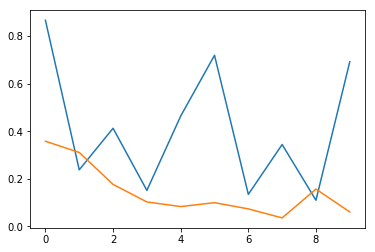

In [24]:
plt.plot(train_losses)
plt.plot(test_losses)

## Single image through the model

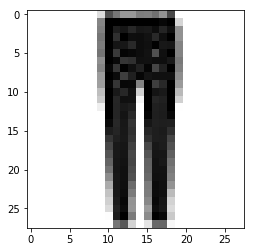

In [50]:
x = 1991
im = test_data[x][0].reshape(28,28)
plt.imshow(im,cmap="gist_yarg")

In [51]:
model.eval()
with torch.no_grad():
    pic = test_data[x][0]
    pic = pic.to(torch.device('cuda:0'))
    new_pred = model(pic.view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())
print("Label: ", class_names[new_pred.item()] )

Predicted value: 1
Label:  Trouser


In [52]:
torch.save(model.state_dict(), 'CNN_Fashion-MNIST.pt')